<a href="https://colab.research.google.com/github/AnmolRajpoot25/LLMs_Learning_Modules-_sequential/blob/main/Build_a_large_language_model_chap_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Implementing a GPT model from scratch  to generate Text

# 4.1 Coding of an LLM Architecture

In [1]:
GPT_CONFIG_124M={
    "vocab_size" : 50257,
    "context_length" : 1024,
    "emb_dim": 768,
    "n_heads" : 12 ,
    "n_layers": 12 ,
    "drop_rate" : 0.1,
    "qkv_bias" : False
}

In [2]:
import  torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])


        self .trf_blocks = nn.Sequential(*[
           DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = DummyLayerNorm(cfg["emb_dim"])

        self.out_head = nn.Linear( cfg["emb_dim"], cfg["vocab_size"], bias = False)



    def forward(self, in_idx):
      batch_size , seq_len = in_idx.shape
      tok_embeds = self.tok_emb(in_idx)
      pos_embeds = self.pos_emb(torch.arange(seq_len, device = in_idx.device))
      x = tok_embeds + pos_embeds
      x= self.drop_emb(x)
      x = self.trf_blocks(x)
      x = self.final_norm(x)
      logits = self.out_head(x)
      return logits



class DummyTransformerBlock(nn.Module):
  def __init__(self, normalized_shape, eps = 1e-5 ):
    super().__init__()



  def forward( self , x):
   return x

class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()



    def forward( self , x):
     return x



In [3]:
import  tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []

txt1 = "Every efforts moves you"
txt2 = "Every day holds a"

batch.append( torch.tensor(tokenizer.encode(txt1 )))
batch.append( torch.tensor(tokenizer.encode(txt2 )))
batch= torch.stack(batch , dim =0)
print ( batch )

tensor([[6109, 4040, 6100,  345],
        [6109, 1110, 6622,  257]])


In [4]:
torch.manual_seed(123)
model = DummyGPTModel( cfg = GPT_CONFIG_124M)

logits = model(batch)
print ("output shape : ", logits.shape)
print(logits)

output shape :  torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.9125,  1.5573, -0.5135,  ..., -0.3851,  0.6555,  1.5411],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6755, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


# 4.2 Normalizing activations with the layer normalization

In [5]:
torch.manual_seed(123)


batch_example = torch.randn(2,5 )
batch_example

tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969],
        [ 0.2093, -0.9724, -0.7550,  0.3239, -0.1085]])

In [6]:
layer = nn.Sequential(nn.Linear(5,6) , nn.ReLU())
out = layer(batch_example)
out

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)

In [7]:
out.shape

torch.Size([2, 6])

In [8]:
mean = out.mean(dim = -1 , keepdim = True )
mean

tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)

In [9]:
var = out.var(dim =-1 , keepdim = True )
var

tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)

In [10]:
norm = ((out- mean)/torch.sqrt(var))
norm.var(dim = -1, keepdim = True )

tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)

In [11]:
torch.set_printoptions(sci_mode = False )

In [12]:
class LayerNorm (nn.Module):
  def __init__(self , emb_dim):
    super().__init__()
    self .eps = 1e-5
    self.scale= nn.Parameter( torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))


  def forward( self , x ):
    mean = x.mean( dim =-1 , keepdim = True )
    var = x.var(dim = -1 , keepdim = True )
    norm_x = ( x-mean )/torch.sqrt( var + self.eps )
    return self.scale*norm_x + self.shift


In [13]:
ln = LayerNorm(6)
output_normed = ln(out)
output_normed

tensor([[ 0.6157,  1.4123, -0.8717,  0.5871, -0.8717, -0.8717],
        [-0.0189,  0.1121, -1.0875,  1.5171,  0.5647, -1.0875]],
       grad_fn=<AddBackward0>)

In [14]:
output_normed.mean(dim =-1 , keepdim = True )

tensor([[-0.0000],
        [ 0.0000]], grad_fn=<MeanBackward1>)

In [15]:
output_normed.var(dim =-1, keepdim = True  )

tensor([[0.9996],
        [0.9997]], grad_fn=<VarBackward0>)

# 4.3 Implementing a feed forward network with GELU activations

In [16]:
class GELU (nn.Module):
  def __init__(self ):
    super().__init__()

  def forward( self, x):
    return 0.5 * x *( 1 + torch.tanh(torch.sqrt(torch.tensor(2.0 /torch.pi)) *
     (x + 0.044715 * torch.pow( x, 3))
     ))

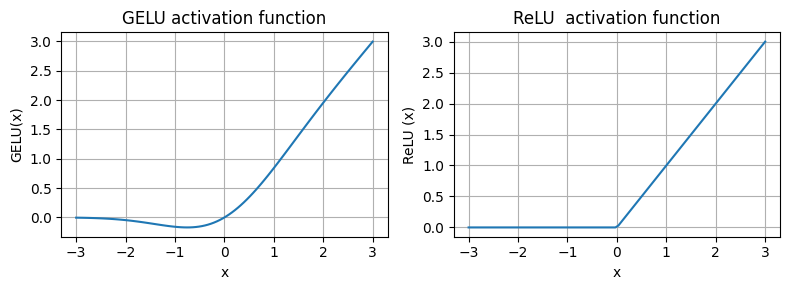

In [17]:
import matplotlib.pyplot as plt
gelu , relu = GELU() , nn.ReLU()


x= torch.linspace( -3 , 3, 100)
y_gelu , y_relu = gelu(x) , relu(x)

plt.figure(figsize= (8,3 ))

for i , ( y, label ) in enumerate (zip([y_gelu , y_relu ], ["GELU", "ReLU " ]), 1 ) :

   plt.subplot(1, 2, i)
   plt.plot(x, y)
   plt.title(f"{label} activation function")
   plt.xlabel("x")
   plt.ylabel(f"{label}(x)")
   plt.grid(True)

plt.tight_layout()
plt.show()

In [18]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)


In [19]:

print(GPT_CONFIG_124M["emb_dim"])

768


In [20]:
ffn = FeedForward(GPT_CONFIG_124M)

# input shape: [batch_size, num_token, emb_size]
x = torch.rand(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


#  4.4 Adding shortcut connections

In [21]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output = layer(x)
            # Check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x


def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Calculate loss based on how close the target
    # and output are
    loss = nn.MSELoss()
    loss = loss(output, target)

    # Backward pass to calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")


In [22]:
#  without  shortcut
layer_sizes = [3, 3, 3, 3, 3, 1]

sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173584925942123
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


In [23]:
#  with shortcut
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694105327129364
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


# MULTI HEAD ATTENTION

In [24]:
import torch.nn as nn
import torch

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, num_heads, dropout, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1).bool())

    def forward(self, x):
        batch_size, num_tokens, d_in = x.shape

        queries = self.W_query(x)
        keys = self.W_key(x)
        values = self.W_value(x)

        queries = queries.view(batch_size, num_tokens, self.num_heads, self.head_dim)
        keys = keys.view(batch_size, num_tokens, self.num_heads, self.head_dim)
        values = values.view(batch_size, num_tokens, self.num_heads, self.head_dim)

        queries = queries.transpose(1, 2)
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)

        attn_scores = torch.matmul(queries, keys.transpose(2, 3)) / (self.head_dim**0.5)

        if self.mask.shape[0] >= num_tokens:
            attn_scores.masked_fill_(self.mask[ :num_tokens, :num_tokens], float('-inf'))

        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = torch.matmul(attn_weights, values)

        context_vec = context_vec.transpose(1, 2).contiguous().view(batch_size, num_tokens, self.d_out)

        context_vec = self.out_proj(context_vec)
        return context_vec

# 4.5 Connecting attention and linear layers in a transformer block

In [25]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.attn = MultiHeadAttention(
            d_in = cfg["emb_dim"],
            d_out = cfg["emb_dim"],
            context_length = cfg["context_length"],
            num_heads = cfg["n_heads"],
            dropout = cfg["drop_rate"],
            qkv_bias = cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut= nn.Dropout(cfg["drop_rate"])

    def forward ( self , x ):
      shortcut = x
      x = self.norm1(x)
      x = self.attn(x)
      x= self.drop_shortcut(x)
      x = x+ shortcut




      shortcut = x
      x = self.norm2(x)
      x = self.ff(x)
      x = self.drop_shortcut(x)
      x = x+ shortcut

      return x

In [26]:
torch.manual_seed(123)
x = torch.rand( 2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


# 4.6 coding the GPT Model

In [27]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])


        self .trf_blocks = nn.Sequential(*[
           TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])

        self.out_head = nn.Linear( cfg["emb_dim"], cfg["vocab_size"], bias = False)



    def forward(self, in_idx):
      batch_size , seq_len = in_idx.shape
      tok_embeds = self.tok_emb(in_idx)
      pos_embeds = self.pos_emb(torch.arange(seq_len, device = in_idx.device))
      x = tok_embeds + pos_embeds
      x= self.drop_emb(x)
      x = self.trf_blocks(x)
      x = self.final_norm(x)
      logits = self.out_head(x)
      return logits



class TransformerBlock(nn.Module):
  def __init__(self, normalized_shape, eps = 1e-5 ):
    super().__init__()



  def forward( self , x):
   return x

class LayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()



    def forward( self , x):
     return x

In [28]:
torch.manual_seed(123)

model = GPTModel( GPT_CONFIG_124M)

out = model(batch)

In [29]:
print( model.tok_emb.weight.shape )
print( model.out_head.weight.shape )

torch.Size([50257, 768])
torch.Size([50257, 768])


In [30]:
print (batch.shape)
print (out.shape )

torch.Size([2, 4])
torch.Size([2, 4, 50257])


In [31]:
batch.numel()

8

In [32]:
total_parameter = sum (p.numel() for p in model.parameters())
total_parameter
# print(f"{total_parameter:, }")

77981184

# 4.7 Generating Text

In [73]:
def generate_text_simple(model, idx , max_new_tokens, context_size):
  for _ in range(max_new_tokens):
      idx_cond = idx[:, -context_size: ]

      with torch.no_grad():
          logits = model(idx_cond)
      logits= logits[:,-1, :]

      probas = torch.softmax(logits, dim = -1 )

      idx_next = torch.argmax(probas, dim = -1 , keepdim = True)

      idx = torch.cat(( idx , idx_next), dim =1 )


  return idx


In [74]:
torch.argmax(torch.tensor([14, 1, -2 ,1, 5]))

tensor(0)

In [75]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print(start_context)
print( encoded)

Hello, I am
[15496, 11, 314, 716]


In [76]:
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape :", encoded_tensor.shape)

encoded_tensor.shape : torch.Size([1, 4])


In [77]:
out = generate_text_simple(
                           model = model,
                           idx = encoded_tensor,
                           max_new_tokens =6,
                           context_size= GPT_CONFIG_124M["context_length"]
                           )

print("Output :", out )
print("output_Length:", len(out[0]))

Output : tensor([[15496,    11,   314,   716, 16176, 41178,  8872, 31167, 47873, 26055]])
output_Length: 10


In [78]:
out

tensor([[15496,    11,   314,   716, 16176, 41178,  8872, 31167, 47873, 26055]])

In [79]:
# tokenizer.decode(out)

In [80]:
decoded= tokenizer.decode(out.squeeze().tolist())
print(decoded)

Hello, I am pelRoom dollar deliveries convergeHen


In [81]:
p =out.squeeze
p

<function Tensor.squeeze>

In [82]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded", encoded )


encoded [15496, 11, 314, 716]


In [83]:
encoded_tensor = torch.tensor(encoded).unsqueeze(0)

print ("encoded_tensor.shape:", encoded_tensor.shape)

encoded_tensor.shape: torch.Size([1, 4])


In [84]:
encoded_tensor

tensor([[15496,    11,   314,   716]])